In [1]:
import pyspark.sql
import pyspark.sql.functions as F
from pyspark.sql.types import *

import matplotlib.pyplot as plt

In [2]:
spark = pyspark.sql.SparkSession.builder.appName('practise').getOrCreate()

In [3]:
spark

In [4]:
HOUSING_DATA = 'cal_housing.data/'

In [5]:
schema = StructType([
    StructField("Longitude" , FloatType() , nullable=True),
    StructField("Latitude" , FloatType() , nullable=True),
    StructField("Housing Median Age" , FloatType() , nullable=True),
    StructField("Total Rooms" , FloatType() , nullable=True),
    StructField("Total Bedrooms" , FloatType() , nullable=True),
    StructField("Population" , FloatType() , nullable=True),
    StructField("Households" , FloatType() , nullable=True),
    StructField("Median Income" , FloatType() , nullable=True),
    StructField("Median House Value" , FloatType() , nullable=True)
])

In [6]:
housing_df = spark.read.csv(HOUSING_DATA , header = True , 
                       schema=schema , inferSchema=True)

In [7]:
housing_df.printSchema()

root
 |-- Longitude: float (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Housing Median Age: float (nullable = true)
 |-- Total Rooms: float (nullable = true)
 |-- Total Bedrooms: float (nullable = true)
 |-- Population: float (nullable = true)
 |-- Households: float (nullable = true)
 |-- Median Income: float (nullable = true)
 |-- Median House Value: float (nullable = true)



so let's modifing the columns names

In [8]:
housing_df = housing_df.toDF(*[col_name.replace(' ' ,'_').lower() for col_name in housing_df.columns])

In [9]:
housing_df.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)



# EDA

here we can aggerate our data using pyspark or we can transform to the pandas

In [10]:
housing_df.toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.250000,37.849998,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0
...,...,...,...,...,...,...,...,...,...
20634,-121.089996,39.480000,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20635,-121.209999,39.490002,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20636,-121.220001,39.430000,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20637,-121.320000,39.430000,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


for any regression problem the first thing to do is to check the distribution of the target variable

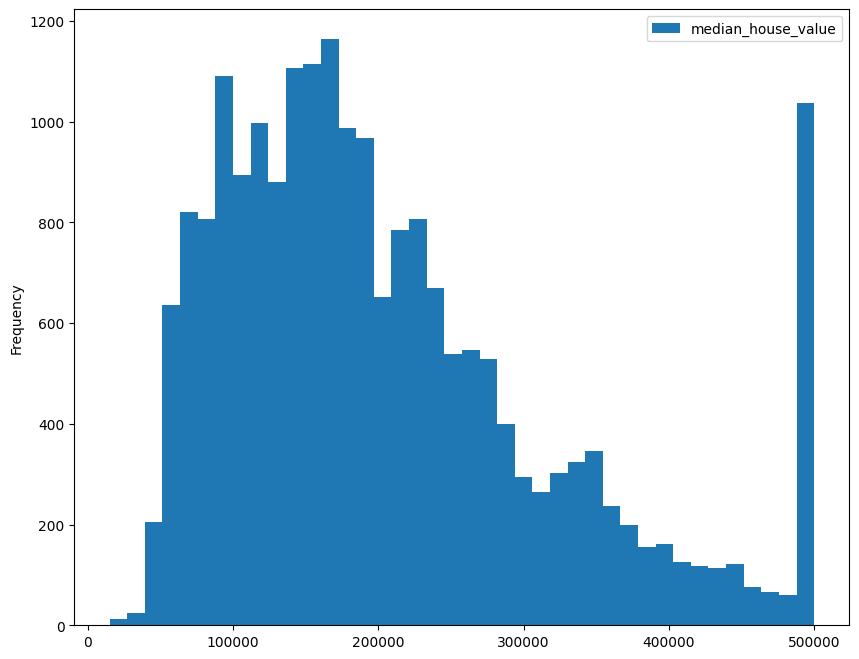

In [11]:
housing_df.select(F.col('median_house_value')).toPandas().plot.hist(bins = 40,
                  figsize = (10,8))
plt.show()

not perfect but acceptable otherwise take the log transformation

In [12]:
def return_summary(df):
    """
    return the rounded summary of dataframe
    """
    housing_df_describe = df.summary()
    for col in housing_df_describe.columns[1:]:
        housing_df_describe = housing_df_describe.withColumn(col , F.round(col , 2))

    return housing_df_describe.toPandas().set_index('summary')

In [13]:
return_summary(housing_df)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
summary,,,,,,,,,
count,20639.00,20639.00,20639.00,20639.00,20639.00,20639.00,20639.00,20639.00,20639.00
mean,-119.57,35.63,28.64,2635.85,537.92,1425.53,499.56,3.87,206843.91
stddev,2.00,2.14,12.59,2181.63,421.25,1132.46,382.33,1.90,115385.73
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1448.00,295.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3147.00,647.00,1725.00,605.00,4.74,264700.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


nice we don't have zero values

# Feature Engineering

In [14]:
housing_df = (housing_df.withColumn("rmsperhh", F.round(F.col("total_rooms")/F.col("households"), 2))
                       .withColumn("popperhh", F.round(F.col("population")/F.col("households"), 2))
                       .withColumn("bdrmsperrm", F.round(F.col("total_bedrooms")/F.col("total_rooms"), 2)))

In [15]:
housing_df = housing_df.drop(*["longitude" , "latitude"])

In [16]:
housing_df = housing_df.withColumn("median_house_value", F.col("median_house_value")/100000)


In [17]:
housing_df.printSchema()

root
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- rmsperhh: double (nullable = true)
 |-- popperhh: double (nullable = true)
 |-- bdrmsperrm: double (nullable = true)



In [18]:
housing_df.columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm']

In [19]:
feature_cols = ['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm']

preparing for machine learning model

In [20]:
from pyspark.ml.feature import VectorAssembler , StandardScaler

In [21]:
assembler = VectorAssembler(inputCols=feature_cols , outputCol="features")

In [22]:
assembled_df = assembler.transform(housing_df)

that is our input data to the model

In [23]:
assembled_df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[21.0,7099.0,1106...|
|[52.0,1467.0,190....|
|[52.0,1274.0,235....|
|[52.0,1627.0,280....|
|[52.0,919.0,213.0...|
|[52.0,2535.0,489....|
|[52.0,3104.0,687....|
|[42.0,2555.0,665....|
|[52.0,3549.0,707....|
|[52.0,2202.0,434....|
|[52.0,3503.0,752....|
|[52.0,2491.0,474....|
|[52.0,696.0,191.0...|
|[52.0,2643.0,626....|
|[50.0,1120.0,283....|
|[52.0,1966.0,347....|
|[52.0,1228.0,293....|
|[50.0,2239.0,455....|
|[52.0,1503.0,298....|
|[40.0,751.0,184.0...|
+--------------------+
only showing top 20 rows



but first we need to transform ist using standard scaler to make it easy for gradient desecent

In [24]:
standardScaler = StandardScaler(inputCol="features" , outputCol="standardFeatures")

In [25]:
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [26]:
scaled_df.select(['features' , 'standardFeatures']).show(truncate=True)

+--------------------+--------------------+
|            features|    standardFeatures|
+--------------------+--------------------+
|[21.0,7099.0,1106...|[1.66857779678232...|
|[52.0,1467.0,190....|[4.13171644917529...|
|[52.0,1274.0,235....|[4.13171644917529...|
|[52.0,1627.0,280....|[4.13171644917529...|
|[52.0,919.0,213.0...|[4.13171644917529...|
|[52.0,2535.0,489....|[4.13171644917529...|
|[52.0,3104.0,687....|[4.13171644917529...|
|[42.0,2555.0,665....|[3.33715559356465...|
|[52.0,3549.0,707....|[4.13171644917529...|
|[52.0,2202.0,434....|[4.13171644917529...|
|[52.0,3503.0,752....|[4.13171644917529...|
|[52.0,2491.0,474....|[4.13171644917529...|
|[52.0,696.0,191.0...|[4.13171644917529...|
|[52.0,2643.0,626....|[4.13171644917529...|
|[50.0,1120.0,283....|[3.97280427805316...|
|[52.0,1966.0,347....|[4.13171644917529...|
|[52.0,1228.0,293....|[4.13171644917529...|
|[50.0,2239.0,455....|[3.97280427805316...|
|[52.0,1503.0,298....|[4.13171644917529...|
|[40.0,751.0,184.0...|[3.1782434

# Building a machine learning model using sparkML

but first we need to split the data for training and testing

In [27]:
train_data , test_data = scaled_df.randomSplit([0.8 , 0.2 ] , seed=2)

In [28]:
train_data.printSchema()

root
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- rmsperhh: double (nullable = true)
 |-- popperhh: double (nullable = true)
 |-- bdrmsperrm: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardFeatures: vector (nullable = true)



In [29]:
from pyspark.ml.regression import LinearRegression

In [30]:
lr = LinearRegression(featuresCol="standardFeatures", 
                     labelCol="median_house_value" , 
                    predictionCol='predmedhv',# That where we store predciction
                      maxIter=10 ,
                      regParam=0.3,
                      elasticNetParam=0.8 , 
                      standardization=False # As we did before
                     )

In [31]:
linearModel = lr.fit(train_data)

# evaluation

let's see our training metrics

In [32]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8804133184783351


In [33]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6751055862930975


In [34]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.41600451894998003


seems nice what about testing ones

In [35]:
predictions = linearModel.transform(test_data)

saving the predictions in $test  data$ is strange thing if you came from sklearn background but that is the case at spark

In [36]:
predandlabels = predictions.select(["median_house_value" , "predmedhv"])

In [37]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="predmedhv" ,
                               labelCol="median_house_value" , 
                               metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8785091734318277


In [38]:
evaluator = RegressionEvaluator(predictionCol="predmedhv" ,
                               labelCol="median_house_value" , 
                               metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6821494410239334


In [39]:
evaluator = RegressionEvaluator(predictionCol="predmedhv" ,
                               labelCol="median_house_value" , 
                               metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.42725899564009007
